# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Standardizing Data](#standardizing-data)
4. [Loading Position Data](#loading-data)
5. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 5.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 5.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
6. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
7. [Correlation Heatmaps](#correlation-heatmaps)
8. [Principal Component Analysis](#PCA)
   - 8.1 [Defense PCA](#defense-pca)
   - 8.2 [Midfileder PCA](#midfielder-pca)
   - 8.3 [Goalkeeper PCA](#goalkeeper-pca)
   - 8.4 [Forward PCA](#forward-pca)
9. [PCA and Baseline Models](#baseline-models)
   - 9.1 [Defense PCA and Model Baselines](#baseline-models-defense)
      - 9.1.A [Decision Tree](#baseline-models-defense-dt)
      - 9.1.B [Bagging](#baseline-models-defense-bagging)
      - 9.1.C [Logistic Regression](#baseline-models-defense-logreg)
   - 9.2 [Midfielder PCA and Model Baselines](#baseline-models-midfielder)
      - 9.2.A [Decision Tree](#baseline-models-midfielder-dt)
      - 9.2.B [Bagging](#baseline-models-midfielder-bagging)
      - 9.2.C [Logistic Regression](#baseline-models-midfielder-logreg)
   - 9.3 [Goalkeeper PCA and Model Baselines](#baseline-models-goalkeeper)
      - 9.3.A [Decision Tree](#baseline-models-goalkeeper-dt)
      - 9.3.B [Bagging](#baseline-models-goalkeeper-bagging)
      - 9.3.C [Logistic Regression](#baseline-models-goalkeeper-logreg)
   - 9.4 [Forward PCA and Model Baselines](#baseline-models-forward)
      - 9.4.A [Decision Tree](#baseline-models-forward-dt)
      - 9.4.B [Bagging](#baseline-models-forward-bagging)
      - 9.4.C [Logistic Regression](#baseline-models-forward-logreg)


<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


Our main research question is: How can players' skills across different positions in the top five European soccer leagues, derived from performance metrics, be used to predict their salaries? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis to explore similarities across top players and their respective positions.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>


In [74]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 3: Standardizing and Preprocessing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale. Since our project involves the use of PCA, it is essential to standardize the data to ensure that each predictor contributes equally and without bias to the principal components.

In [75]:
def standardize(df):
    
    if 'Player' in df.columns:
        player_column = df['Player']

    if 'Squad' in df.columns:
        squad_column = df['Squad']

    if 'Comp' in df.columns:
        comp_column = df['Comp']
        
    numeric_columns = df.select_dtypes(include='number').columns
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[numeric_columns])

    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    standardized_df['Player'] = player_column.reset_index(drop=True)
    standardized_df['Comp'] = comp_column.reset_index(drop=True)
    standardized_df['Squad'] = squad_column.reset_index(drop=True)
    
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 4: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary. To improve our analysis, we seperated our data into four datasets based on the four different player positions. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our PCA if left combined. Additionally, we rename the predictors to ease interpretability within our notebook.

In [76]:
# Make dataframes
goalkeepers = standardize(pd.read_csv("stats/GK_relevant_stats.csv"))
defenders = standardize(pd.read_csv("stats/DF_relevant_stats.csv"))
midfielders = standardize(pd.read_csv("stats/MF_relevant_stats.csv"))
forwards = standardize(pd.read_csv("stats/FW_relevant_stats.csv"))
salaries = pd.read_csv('stats/salaries.csv')

# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

# Numerate leagues for regression
league_map = {
    'Premier League' : 'Zero',
    'La Liga' : 'One',
    'Bundesliga' : 'Two',
    'Serie A' : 'Three',
    'Ligue 1' : 'Four'
}

defenders['Comp'] = defenders['Comp'].map(league_map)
goalkeepers['Comp'] = goalkeepers['Comp'].map(league_map)
midfielders['Comp'] = midfielders['Comp'].map(league_map)
forwards['Comp'] = forwards['Comp'].map(league_map)
salaries['League'] = salaries['League'].map(league_map)


In [77]:
# Calculate team salary average for those who lack data
team_mean_salary = salaries[salaries['Annual Wage (Euros)'] > 0].groupby('Squad')['Annual Wage (Euros)'].mean()

# Replace 0 salaries with the corresponding team's mean salary
for key in dataframes.keys():
    df1 = dataframes[key]
    merged = df1.merge(salaries, on=['Player', 'Squad'], how='left', suffixes=('_df1', '_df2')).fillna(0)

    # Update df1 'Goals' column with the 'Goals_df2' values from df2 where matches exist
    dataframes[key]['Annual Wage (Euros)'] = merged['Annual Wage (Euros)']

    # Replace missing salaries with team's average
    dataframes[key]['Annual Wage (Euros)'] = dataframes[key].apply(
        lambda row: team_mean_salary[row['Squad']] if row['Annual Wage (Euros)'] == 0 else row['Annual Wage (Euros)'], axis=1
    )

In [78]:
forwards.head()

,Age,Born,Matches Played,Starts,Minutes Played,90-Minute Increments,Goals,Assists,Goals + Assists,Goals (Excl. Penalties),Penalty Goals,Penalty Attempts,Yellow Cards,Red Cards,Expected Goals,Non-Penalty Expected Goals,Expected Assists,Expected Non-Penalty Goals + Assists,Goals per 90,Assists per 90,Goals + Assists per 90,Expected Goals per 90,Expected Assists per 90,Expected Goals + Assists per 90,Non-Penalty Goals per 90,...,Passes into Final Third,Passes into Penalty Area,Progressive Carries,Progressive Runs,Touches,Touches in Defensive Penalty Area,Touches in Defensive Third,Touches in Midfield Third,Touches in Attacking Third,Touches in Attacking Penalty Area,Take-On Attempts,Take-On Successes,Take-On Success %,Tackled,Tackled %,Carries,Total Carry Distance,Progressive Carry Distance,Carries into Final Third,Carries into Penalty Area,Passes Received,Player,Comp,Squad,Annual Wage (Euros)
0,-1.613,1.464,-1.493,-1.034,-1.129,-1.130,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.826,-0.860,-0.823,-0.922,-0.678,-0.291,-0.656,-1.200,-0.638,-1.302,-1.190,...,-0.838,-0.784,-0.801,-1.011,-1.056,-0.900,-0.958,-1.059,-1.001,-0.988,-0.870,-0.821,NaN,-0.897,NaN,-1.023,-0.924,-0.834,-0.848,-0.739,-1.038,Aaron Malouda,Four,Lille,9.546e+05
1,0.642,-0.569,-0.220,-0.563,-0.429,-0.426,-0.548,-0.703,-0.651,-0.538,-0.351,-0.388,-0.414,-0.282,-0.603,-0.601,-0.475,-0.606,-0.299,-0.291,-0.412,-0.553,-0.189,-0.527,-0.498,...,-0.348,-0.712,-0.602,-0.565,-0.385,0.303,-0.551,-0.270,-0.426,-0.394,-0.585,-0.649,-0.776,-0.510,0.766,-0.574,-0.683,-0.712,-0.706,-0.558,-0.357,Aaron Seydel,Two,Darmstadt 98,1.200e+05
2,-0.711,0.561,-1.409,-1.034,-1.053,-1.049,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.782,-0.809,-0.774,-0.866,-0.678,-0.291,-0.656,0.009,-0.234,-0.156,0.102,...,-0.838,-0.639,-0.602,-0.858,-0.928,-0.900,-0.917,-0.984,-0.826,-0.854,-0.766,-0.706,0.436,-0.786,0.034,-0.873,-0.763,-0.684,-0.706,-0.498,-0.901,Abde Ezzalzouli,One,Barcelona,8.093e+06
3,-0.711,0.561,0.628,-0.469,-0.150,-0.151,-0.548,-0.703,-0.651,-0.538,-0.351,0.424,-0.414,-0.282,-0.156,-0.290,-0.674,-0.458,-0.425,-0.291,-0.493,0.138,-0.503,-0.249,-0.128,...,-0.240,-0.134,0.826,0.124,0.171,-0.252,0.223,0.066,0.216,0.162,0.424,0.385,0.009,0.373,-0.182,0.072,0.575,0.831,0.766,1.367,0.162,Abde Ezzalzouli,One,Betis,8.000e+05
4,-1.162,1.238,-1.493,-1.034,-1.119,-1.120,-0.750,-0.703,-0.800,-0.767,-0.351,-0.388,-0.868,-0.282,-0.826,-0.860,-0.823,-0.922,-0.678,-0.291,-0.656,-1.200,-0.638,-1.302,-1.190,...,-0.838,-0.784,-0.801,-0.998,-1.053,-0.900,-0.958,-1.059,-0.997,-0.969,-0.870,-0.821,NaN,-0.897,NaN,-1.019,-0.924,-0.834,-0.848,-0.739,-1.035,Abdellah Raihani,One,Atlético Madrid,6.092e+06


<a id="descriptive-stats"></a>

## <div class='section'>Section 5: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>5.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [79]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>5.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

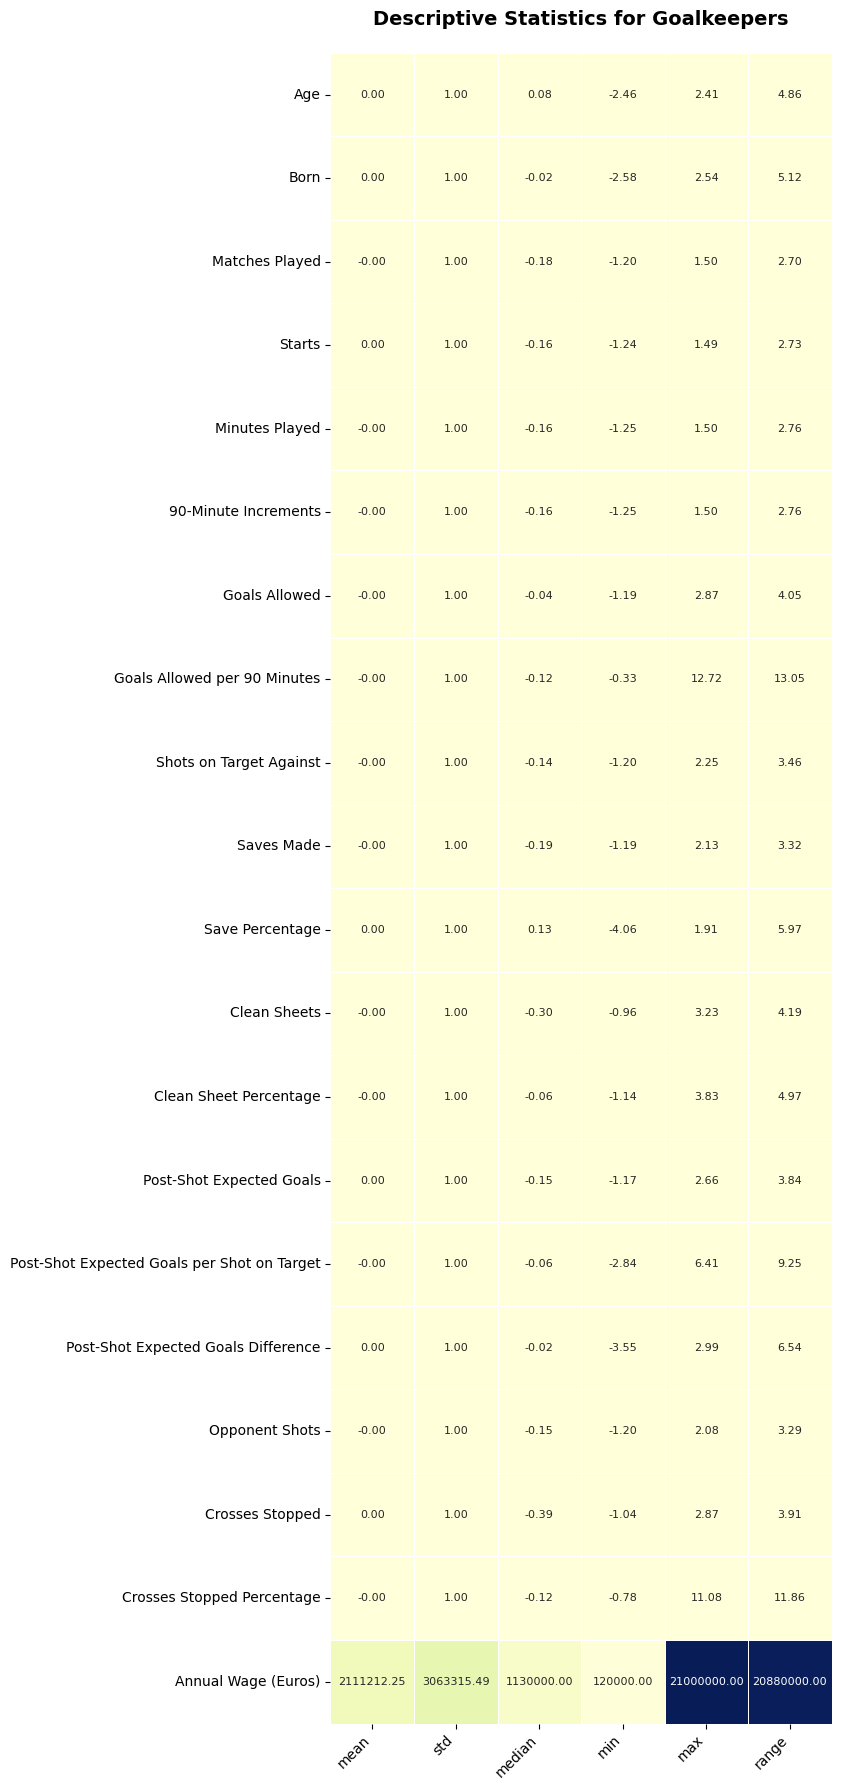

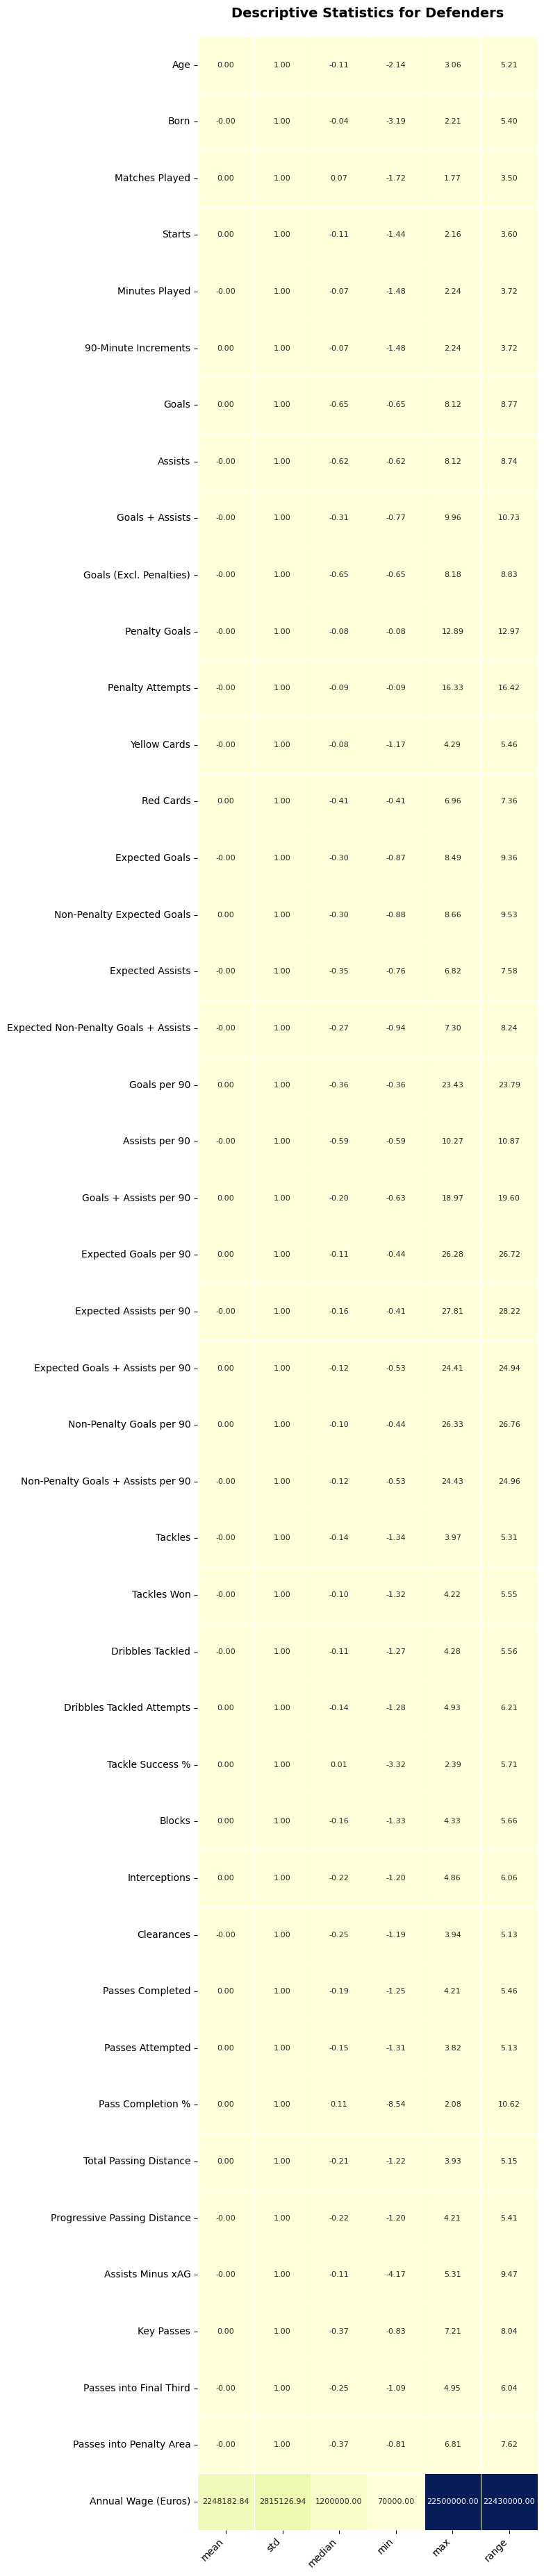

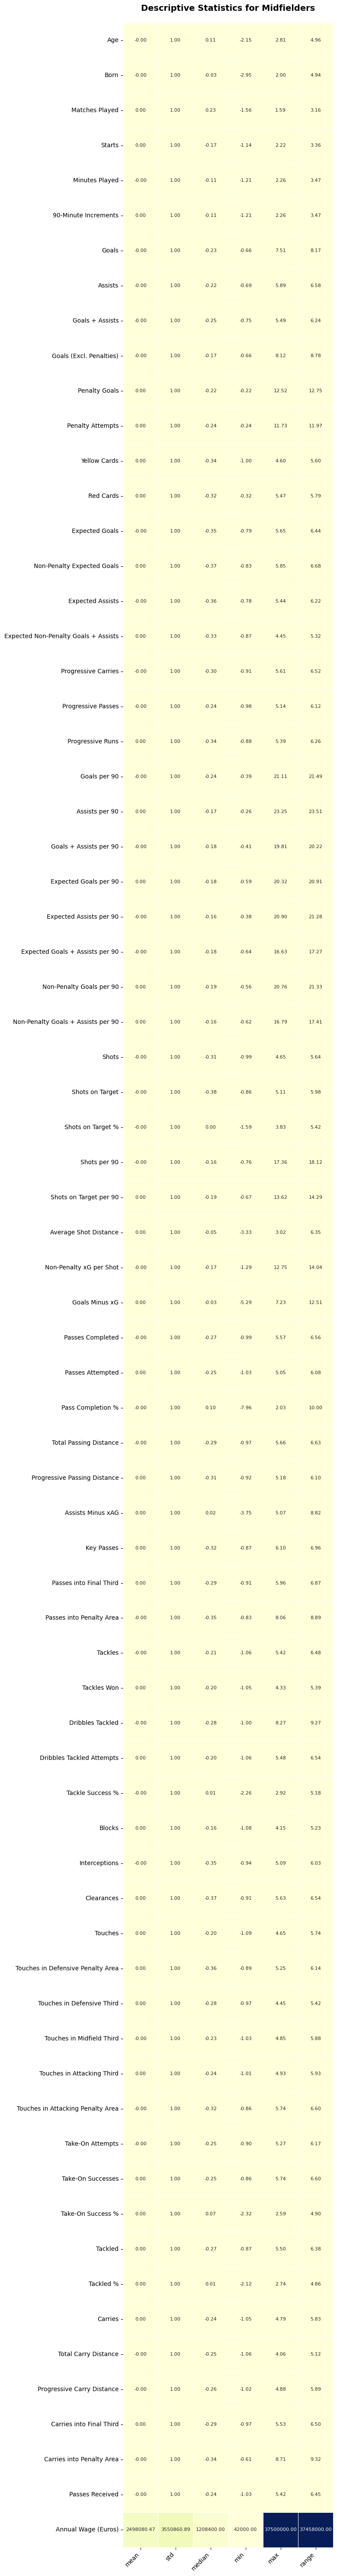

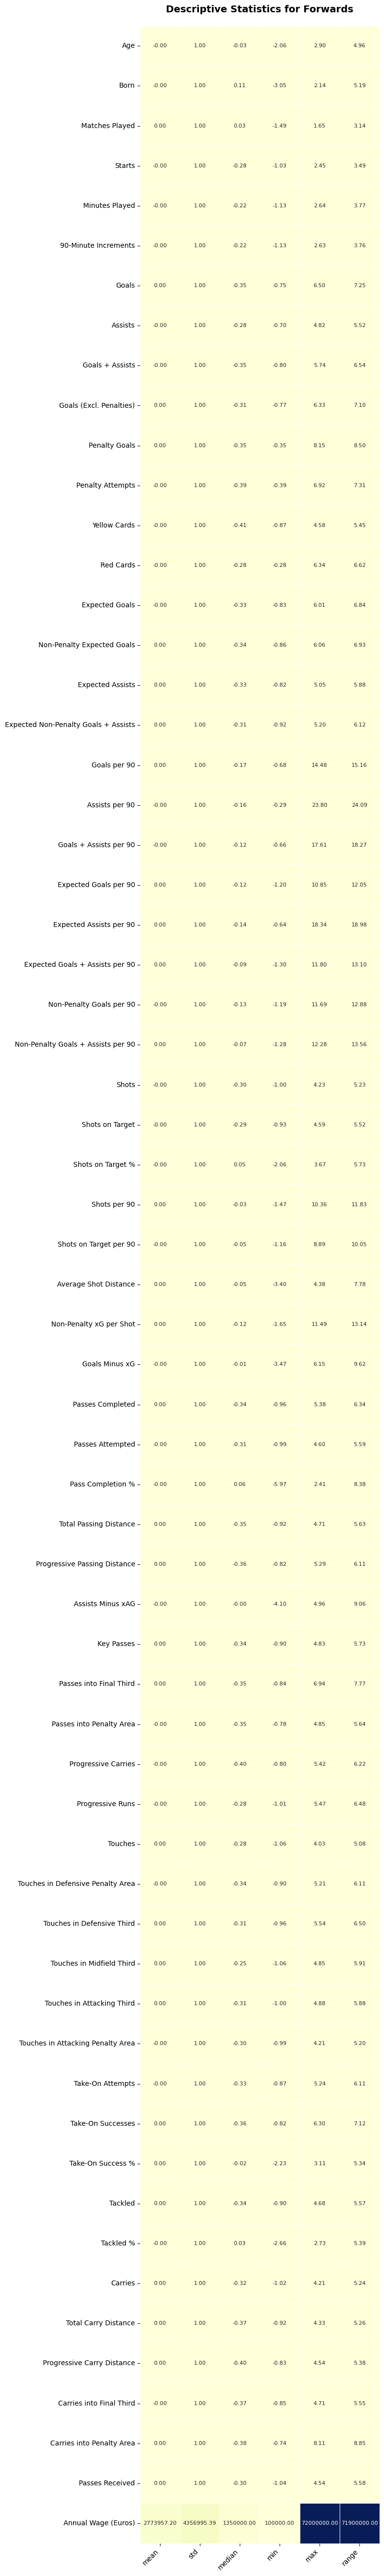

In [80]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.8 + 2))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 6: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


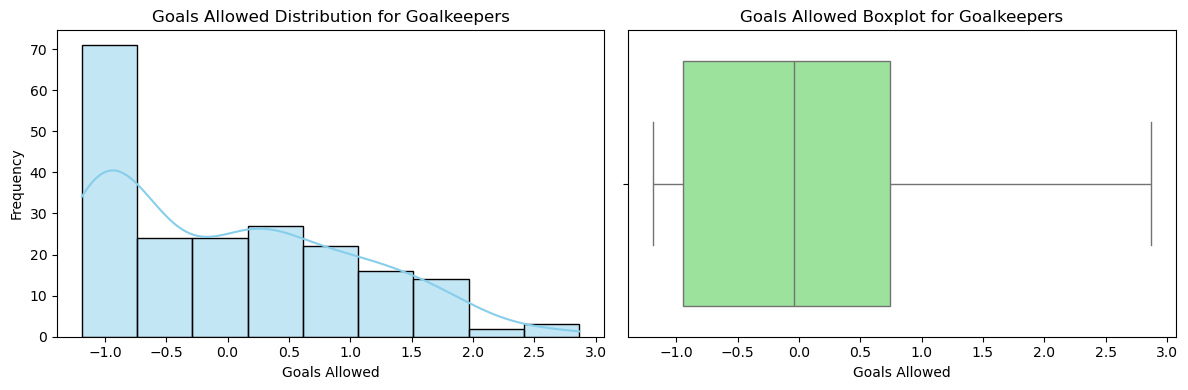

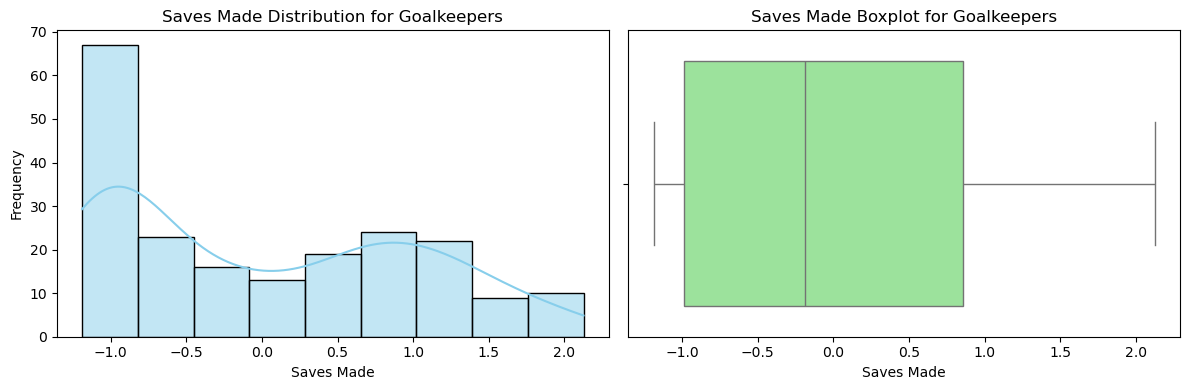

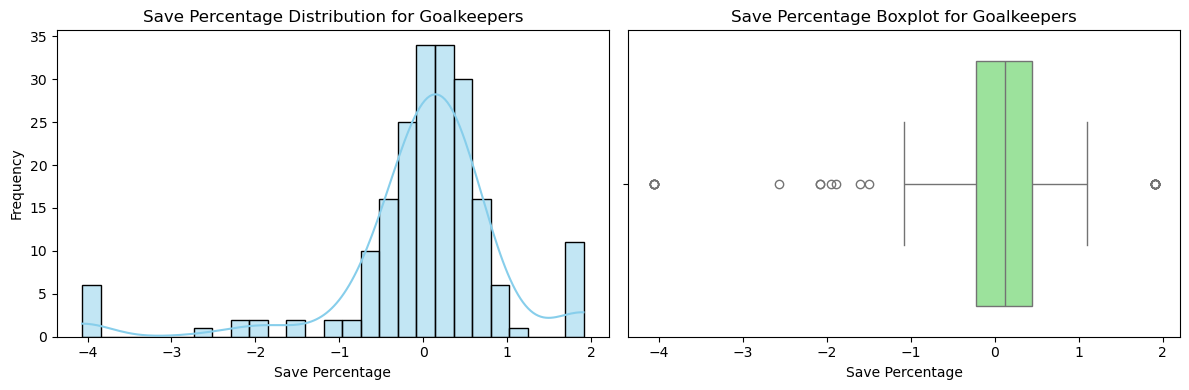

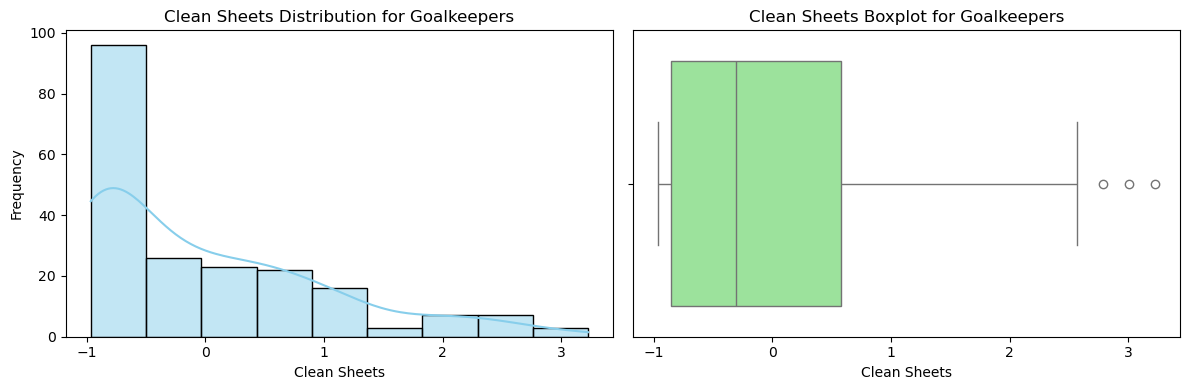

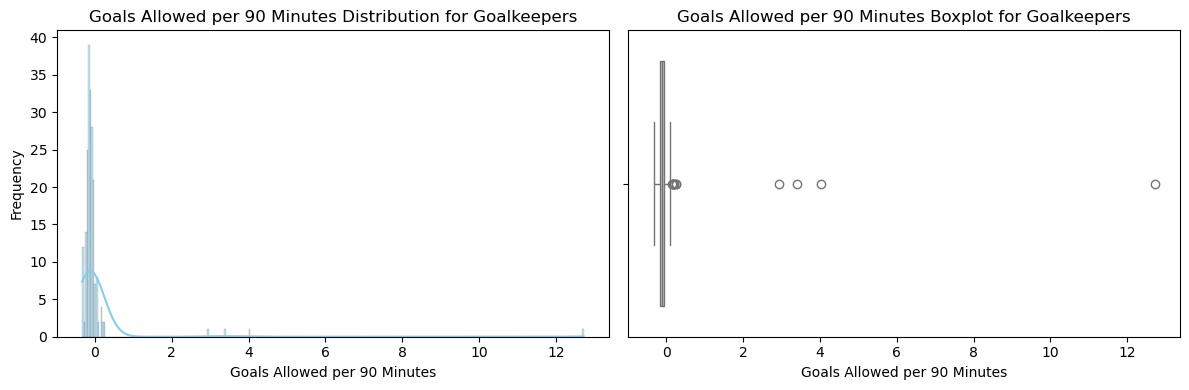

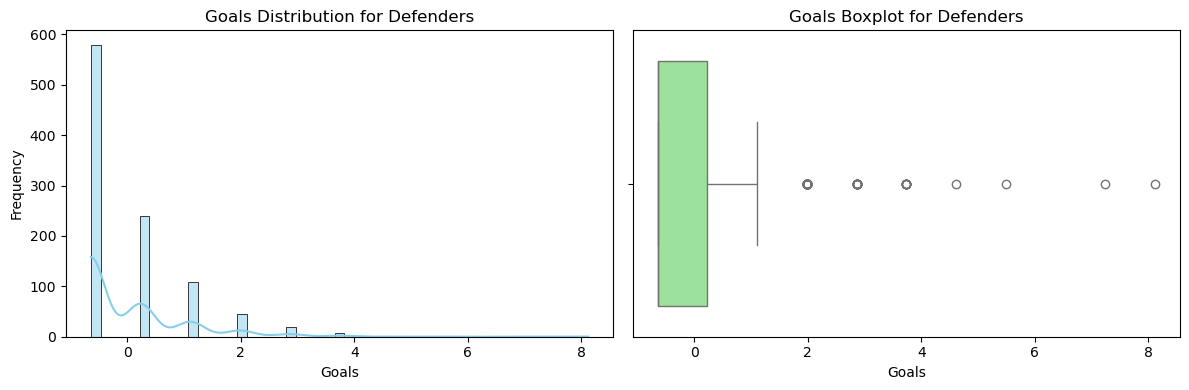

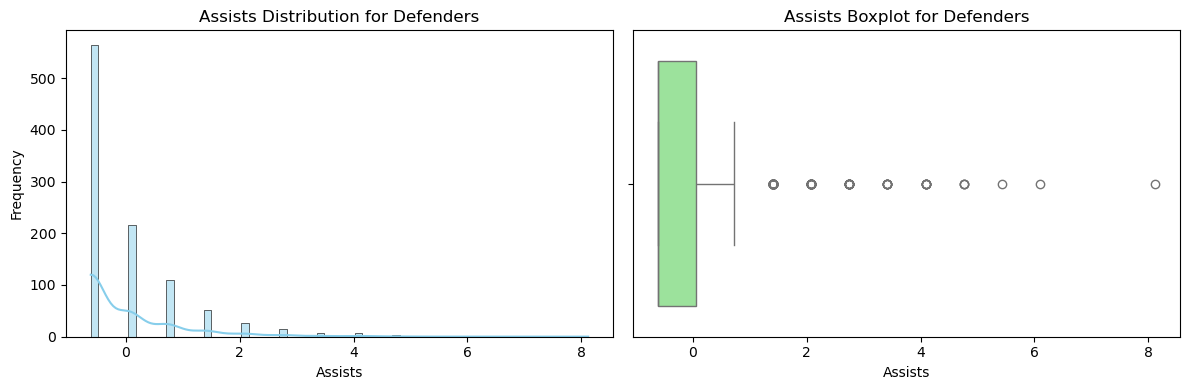

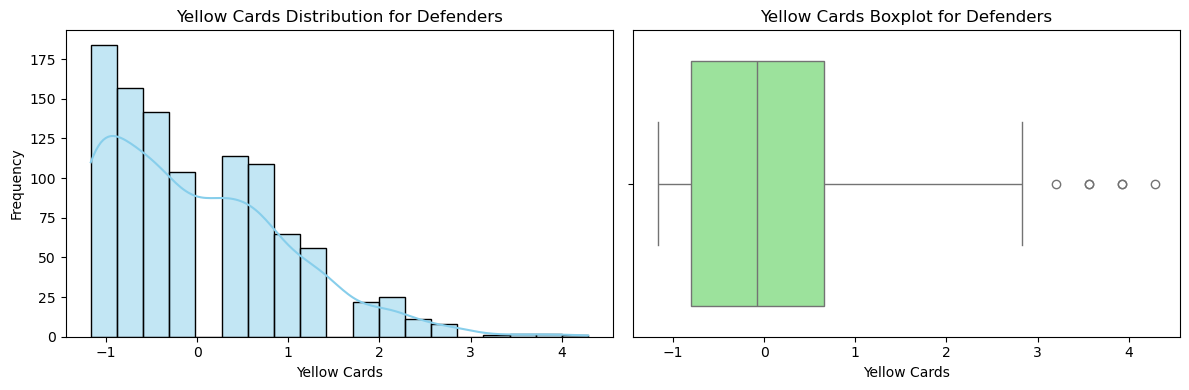

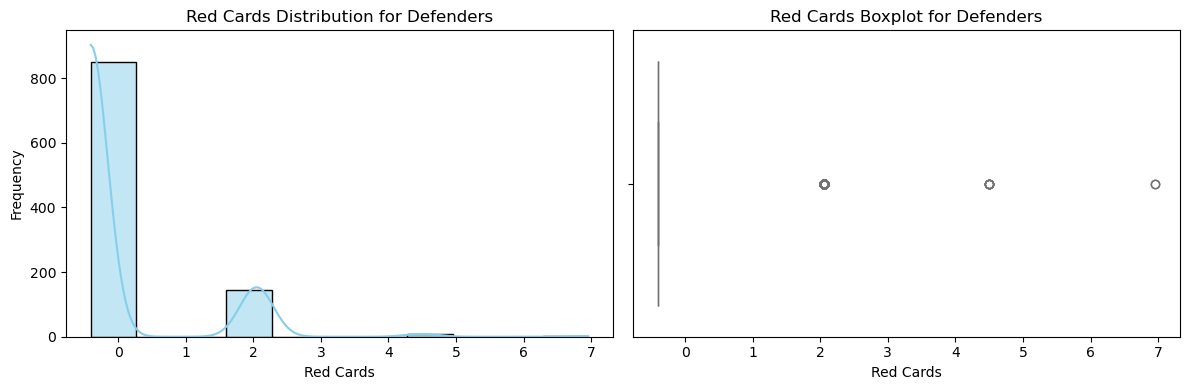

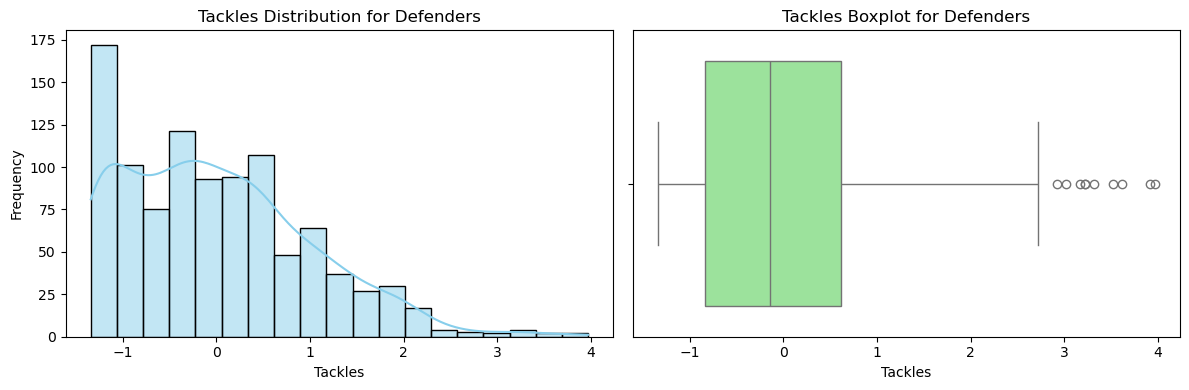

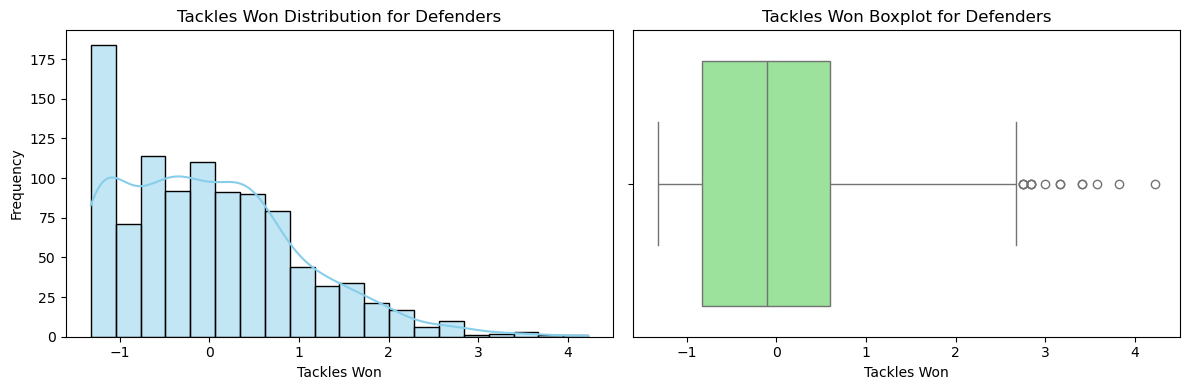

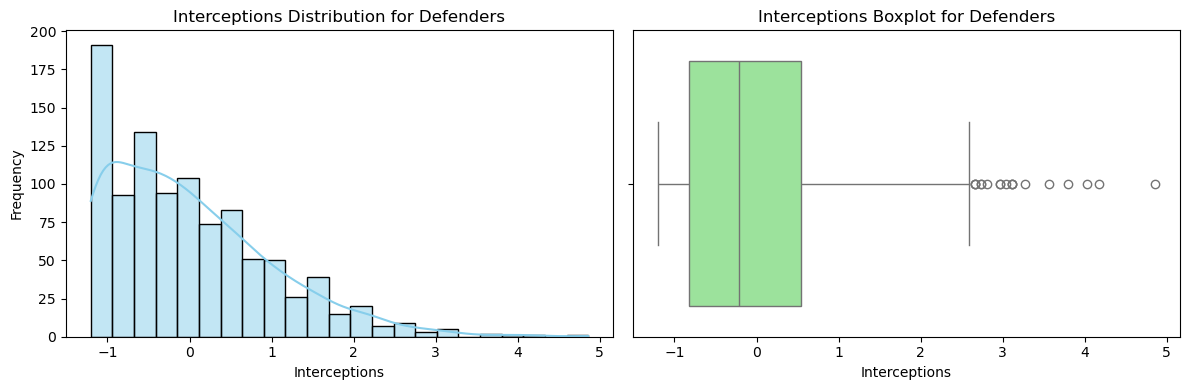

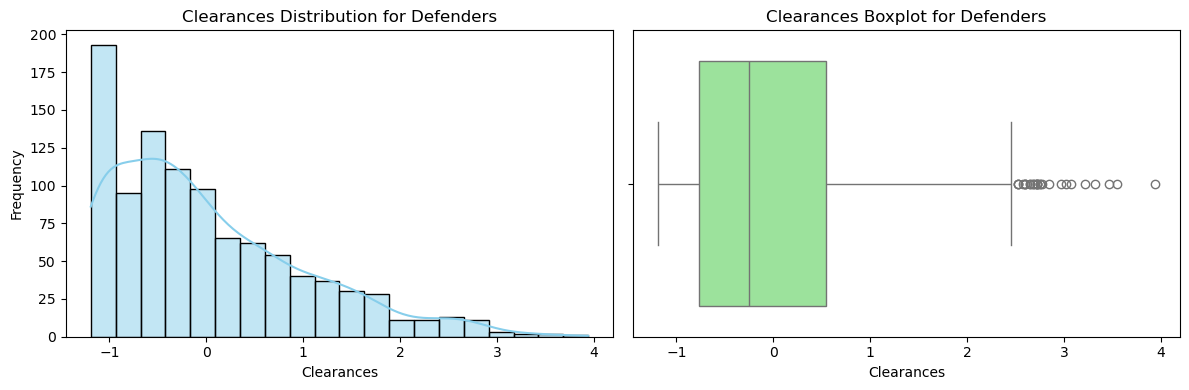

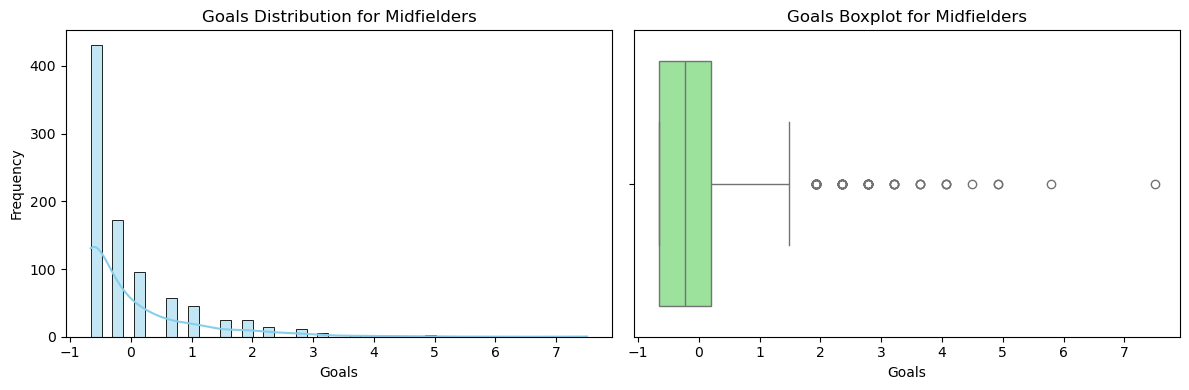

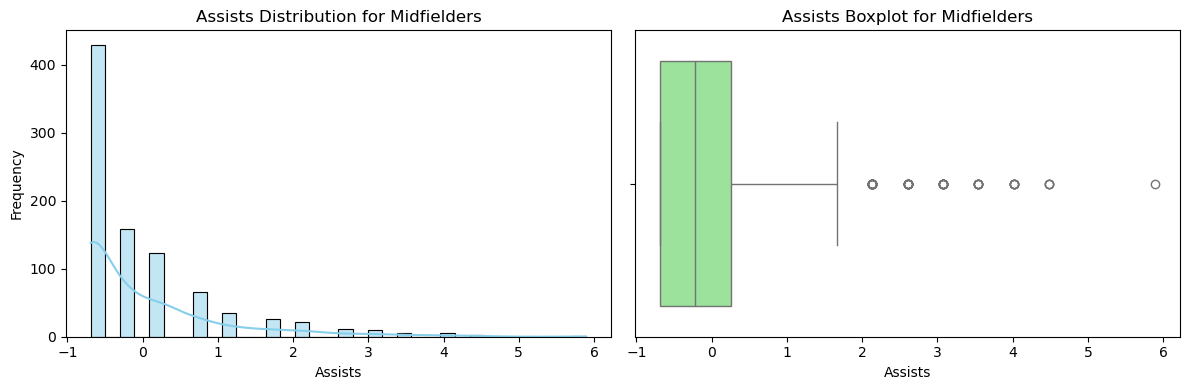

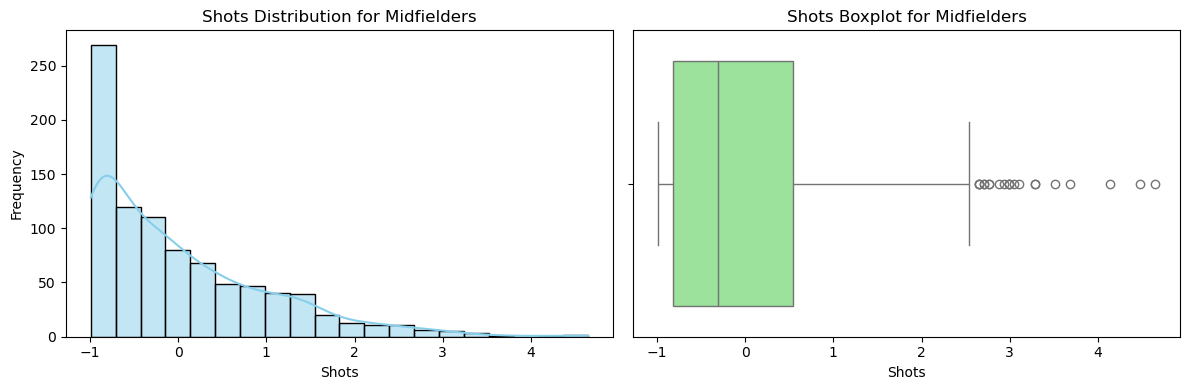

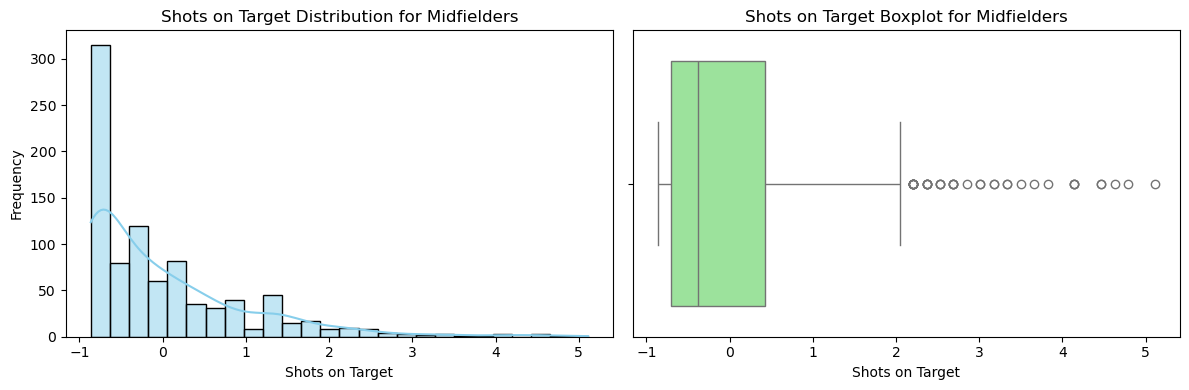

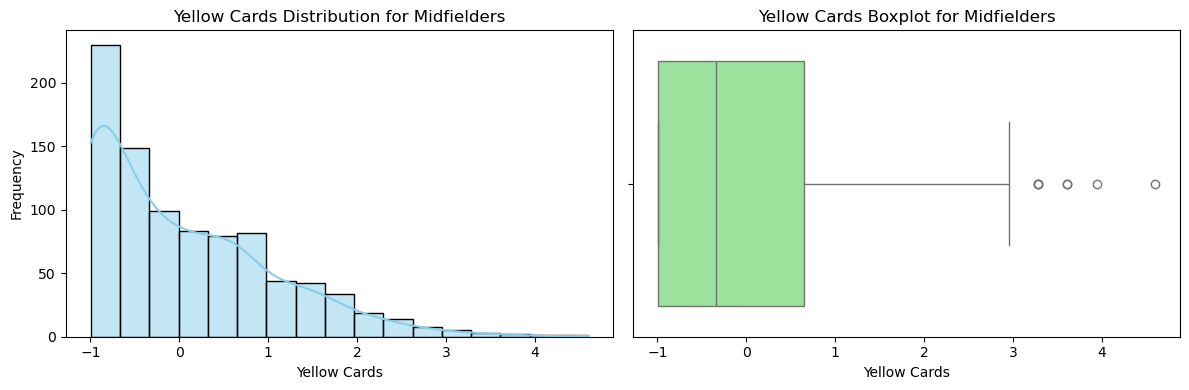

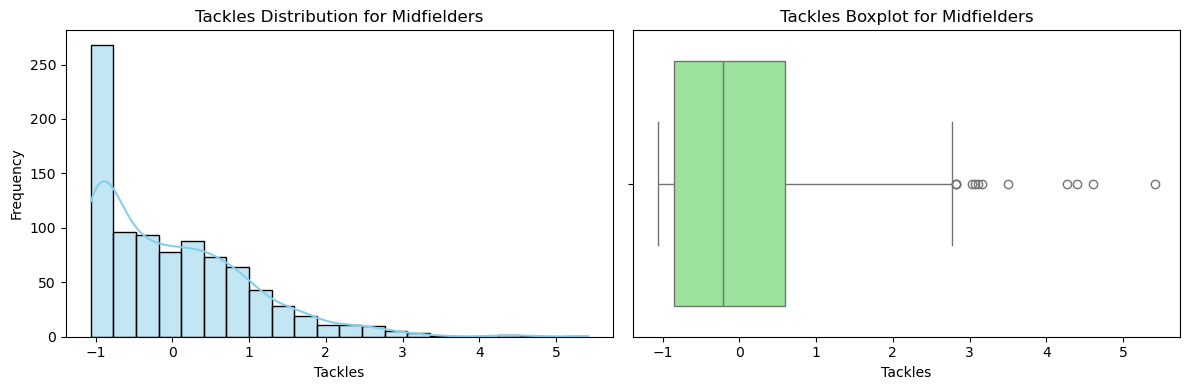

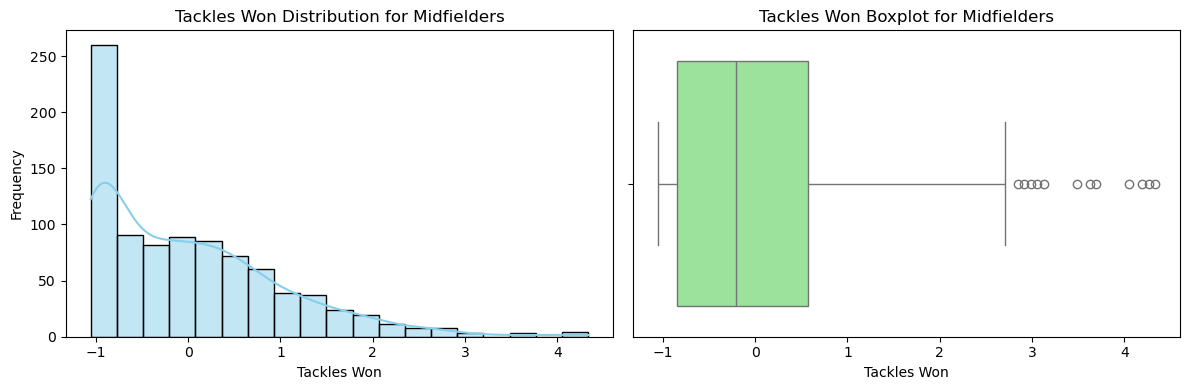

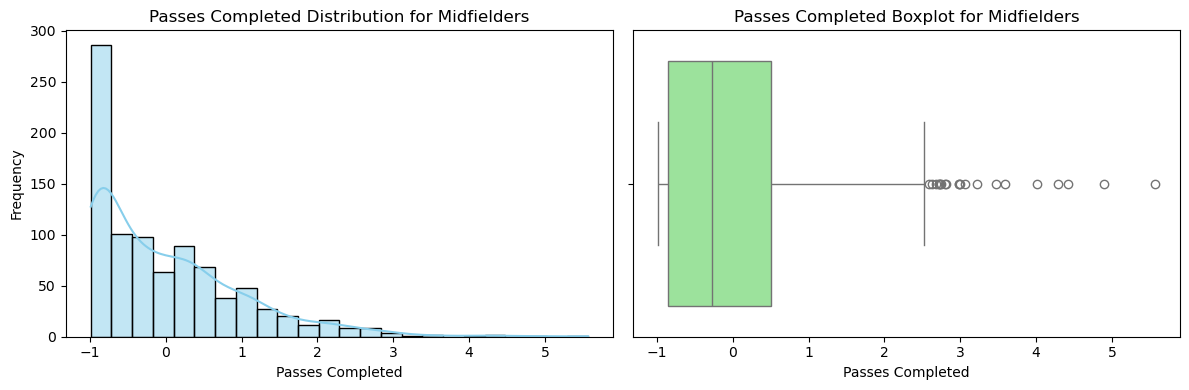

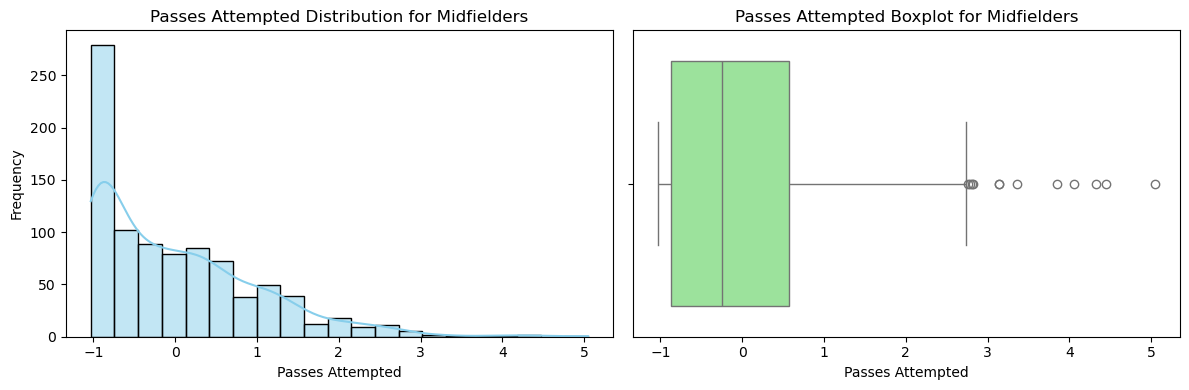

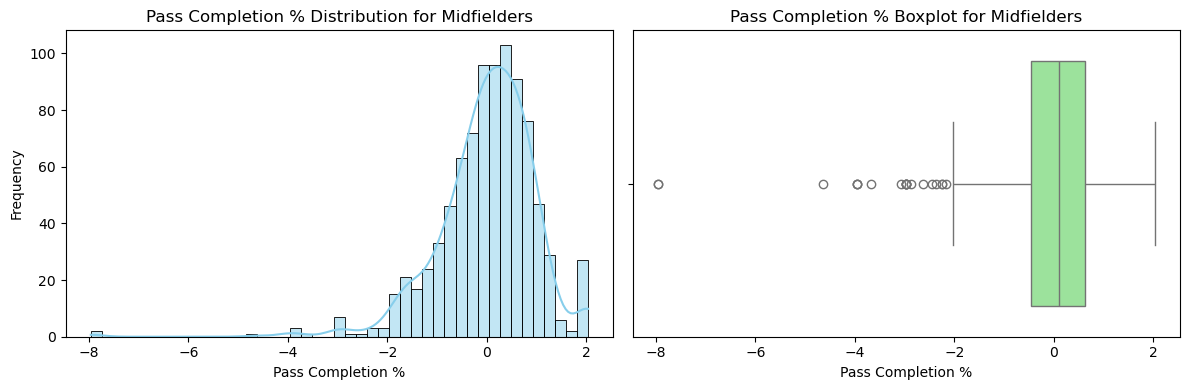

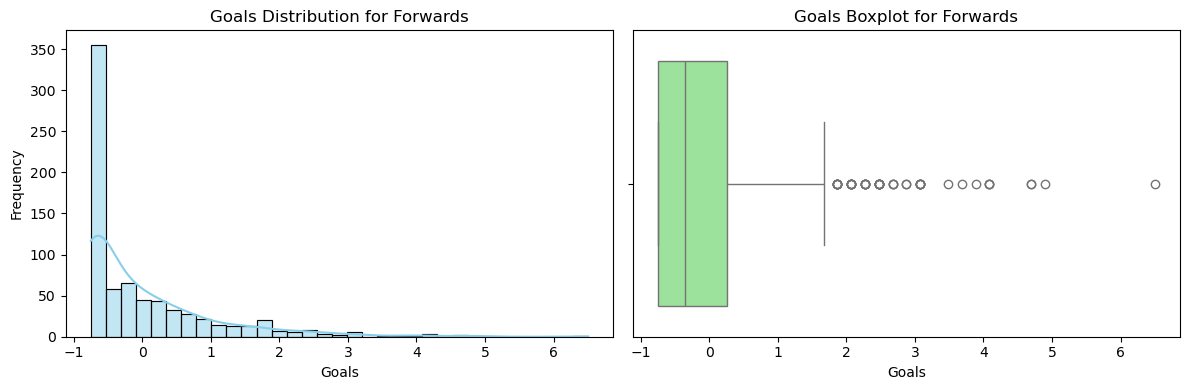

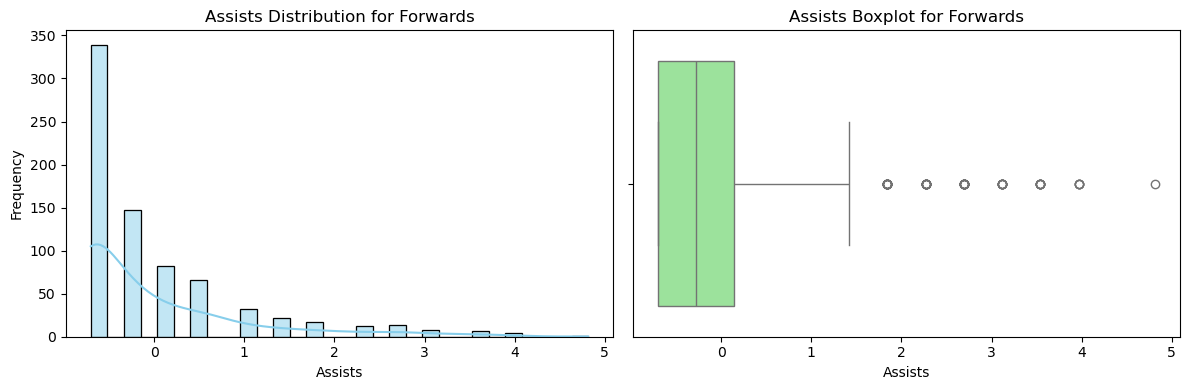

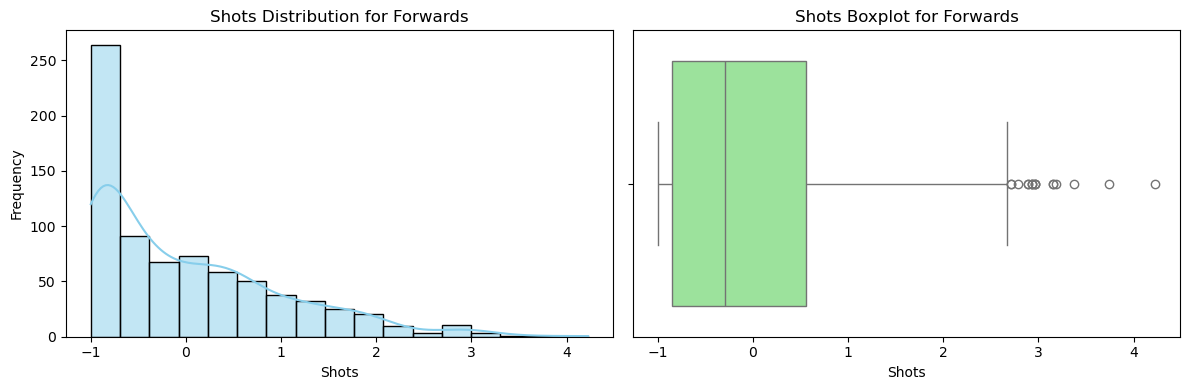

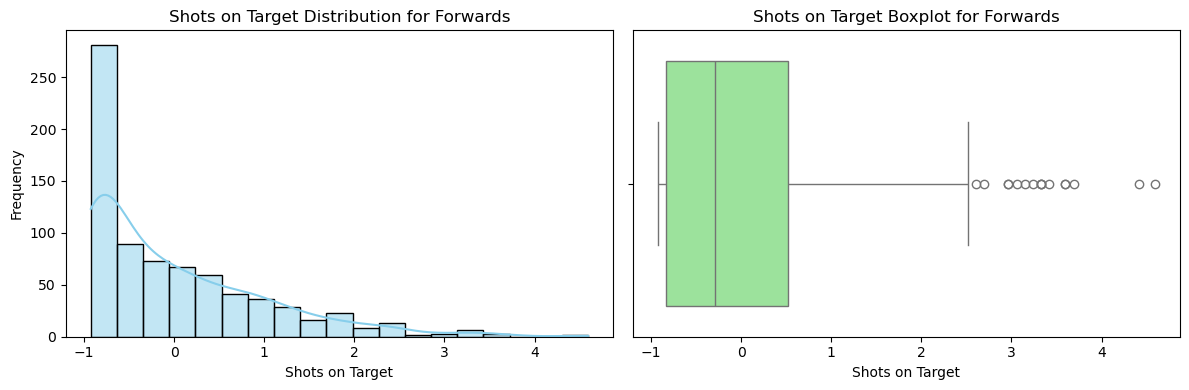

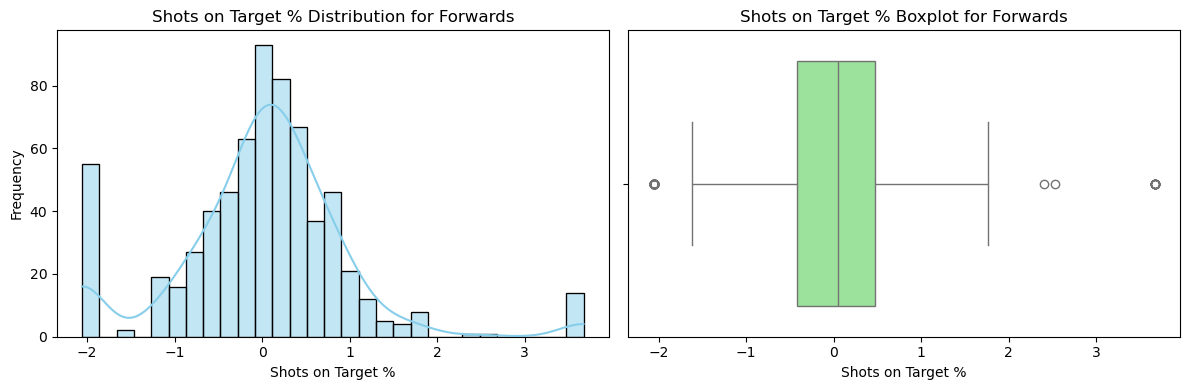

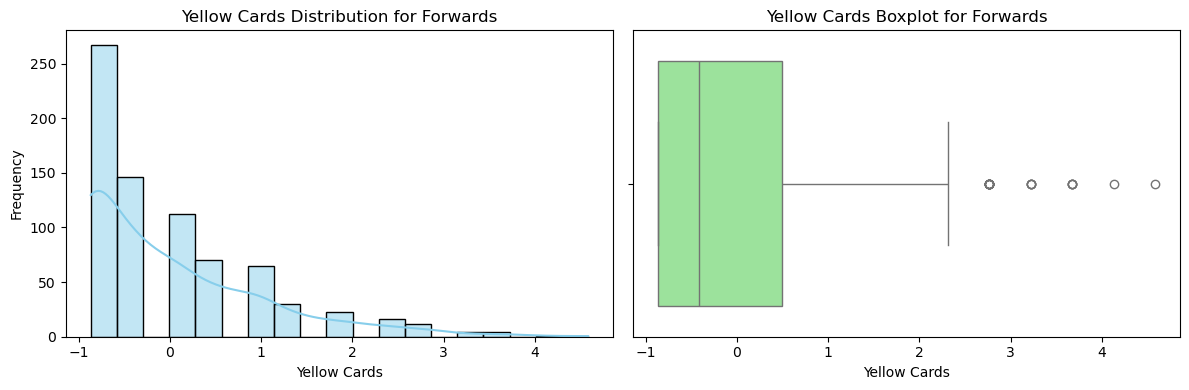

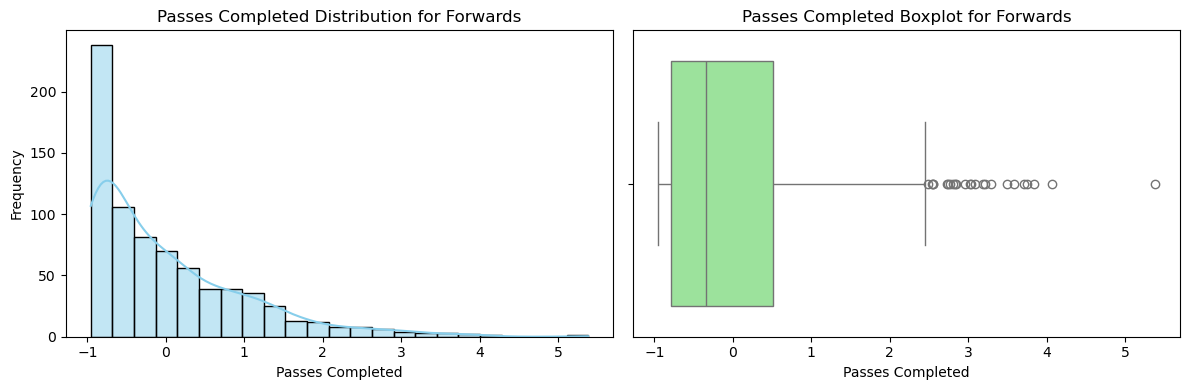

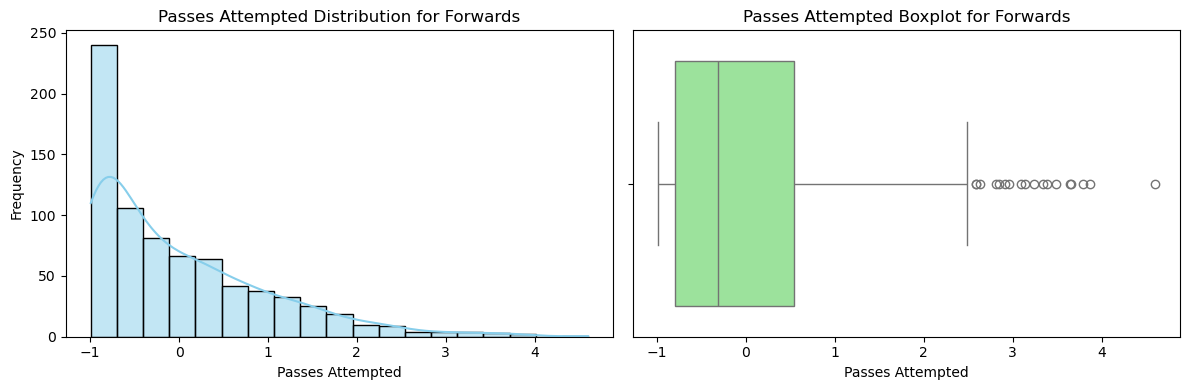

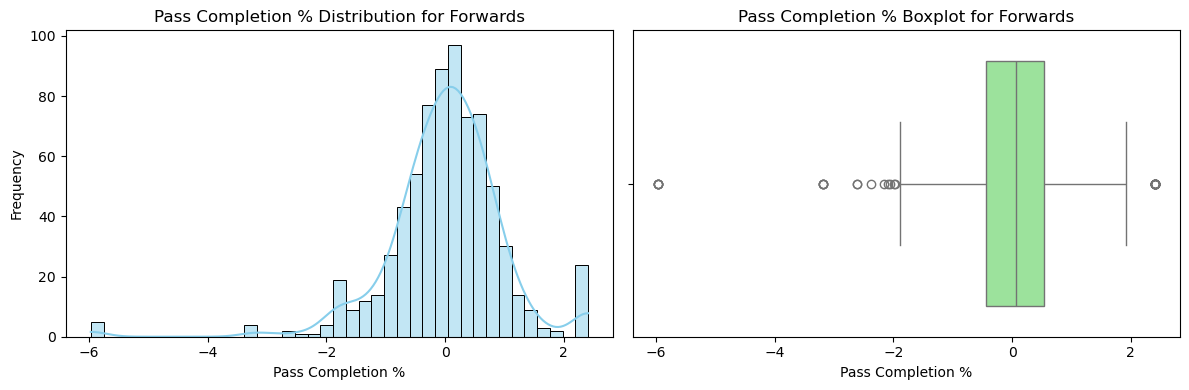

In [84]:

basic_stats = {
    'Goalkeepers': ['Goals Allowed', 'Saves Made', 'Save Percentage', 'Clean Sheets', 'Goals Allowed per 90 Minutes'],
    'Defenders': ['Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'Tackles', 'Tackles Won', 'Interceptions', 'Clearances'],
    'Midfielders': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Yellow Cards', 'Tackles', 'Tackles Won', 'Passes Completed', 'Passes Attempted', 'Pass Completion %'],
    'Forwards': ['Goals', 'Assists', 'Shots', 'Shots on Target', 'Shots on Target %', 'Yellow Cards', 'Passes Completed', 'Passes Attempted', 'Pass Completion %']
}

def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[stat].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[stat].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()

        # saving plots
        filename = f"plots/{position}_{stat}_EDA.png".replace(" ", "_")
        plt.savefig(filename, format='png', dpi=300)
        plt.show()


for position, df in dataframes.items():
    plot_and_save_plots(df, position, basic_stats[position])


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 7: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


In [ ]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    filename = f"heatmap/{position}_correlation_heatmap.png".replace(" ", "_")
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    # save_correlation_heatmap(df, position, basic_stats[position])

print("All correlation heatmaps have been saved as PNG files.")


<a id="PCA"></a>

## <div class='section'>Section 8: Principal Component Analysis</div>

[Return to contents](#contents)

<a id="defense-pca"></a>

### <div class='subsection'>8.1 Defense PCA</div>

In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

defender_train, defender_test = train_test_split(defenders, test_size=0.2, random_state=42)

numeric_train = defender_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
numeric_test = defender_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


defender_train = defender_train.loc[numeric_train.index].reset_index(drop=True)
defender_test = defender_test.loc[numeric_test.index].reset_index(drop=True)


y_train = defender_train['Annual Wage (Euros)']
y_test = defender_test['Annual Wage (Euros)']

pca = PCA()
defender_pca= pca.fit_transform(numeric_train)
defender_pca1= pca.transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()

In order to explain 95% of the variancee, only 15 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [ ]:
defender_train['PC1'] = defender_pca[:, 0]
defender_train['PC2'] = defender_pca[:, 1]

defender_test['PC1'] = defender_pca1[:, 0]
defender_test['PC2'] = defender_pca1[:, 1]

top_defenders = defender_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])

We thought that this this information would be interesting to note so that when we did our later comparisons we could have another metric to use to compare models with each other. These players also tend to be higher-performing.

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(defender_pca[:, 0], defender_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered and spread outwards. It is also apparent that there are no distinct groups outside of the large mass. However, the "top" defenders are at the edges of the cluster due to their high PC1 values. It is interesting to investigate why our higher performing athletes tend to be on the outskirts of the PCA. 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

Here, we can see the most important features to our first principal components. This gives us an idea of what features contribute most to the variance within athletes.

<a id="midfielder-pca"></a>

### <div class='subsection'>8.2 Midfielder PCA</div>

In this section we split the midfielder data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

In [ ]:
midfielders_train, midfielders_test = train_test_split(midfielders, test_size=0.2, random_state=42)

numeric_train = midfielders_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
numeric_test = midfielders_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


midfielders_train = midfielders_train.loc[numeric_train.index].reset_index(drop=True)
midfielders_test = midfielders_test.loc[numeric_test.index].reset_index(drop=True)


y_train = midfielders_train['Annual Wage (Euros)']
y_test = midfielders_test['Annual Wage (Euros)']

pca = PCA()
midfielders_pca= pca.fit_transform(numeric_train)
midfielders_pca1= pca.transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfi')
plt.show()

In order to explain 95% of the variancee, only 19 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [ ]:
midfielders_train['PC1'] = midfielders_pca[:, 0]
midfielders_train['PC2'] = midfielders_pca[:, 1]

midfielders_test['PC1'] = midfielders_pca1[:, 0]
midfielders_test['PC2'] = midfielders_pca1[:, 1]

top_midfielders = midfielders_train.nlargest(10, 'PC1')

print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])

In [ ]:
# graphing PCA with names
plt.figure(figsize=(12, 8))
plt.scatter(midfielders_pca[:, 0], midfielders_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Midfielders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = midfielders_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="goalkeeper-pca"></a>

### <div class='subsection'>8.3 Goalkeeper PCA</div>

In this section we split the goalkeeper data into training and testing data and do a PCA analysis on the training data.

[Return to Section 8](#PCA)

In [ ]:
from sklearn.decomposition import PCA

goalkeepers_train, goalkeepers_test = train_test_split(goalkeepers, test_size=0.2, random_state=42)

numeric_train = goalkeepers_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
numeric_test = goalkeepers_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


goalkeepers_train = goalkeepers_train.loc[numeric_train.index].reset_index(drop=True)
goalkeepers_test = goalkeepers_test.loc[numeric_test.index].reset_index(drop=True)


y_train = goalkeepers_train['Annual Wage (Euros)']
y_test = goalkeepers_test['Annual Wage (Euros)']

pca = PCA()
goalkeepers_pca= pca.fit_transform(numeric_train)
goalkeepers_pca1= pca.transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.show()

In order to explain 95% of the variancee, only 6 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [ ]:
goalkeepers_train['PC1'] = goalkeepers_pca[:, 0]
goalkeepers_train['PC2'] = goalkeepers_pca[:, 1]

goalkeepers_test['PC1'] = goalkeepers_pca1[:, 0]
goalkeepers_test['PC2'] = goalkeepers_pca1[:, 1]

top_goalkeepers= goalkeepers_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_goalkeepers[['Player', 'PC1']])

In [ ]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_goalkeepers.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-10:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 10 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 10 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="forward-pca-2"></a>

### <div class='subsection'>8.4 ForwardPCA</div>


In this section we split the defender data into training and testing data and do a PCA analysis on the training data. 

[Return to Section 8](#PCA)

In [ ]:
forwards_train, forwards_test = train_test_split(forwards, test_size=0.2, random_state=42)

numeric_train = forwards_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()
numeric_test = forwards_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').drop(columns=['Annual Wage (Euros)'], errors='ignore').dropna()


forwards_train = forwards_train.loc[numeric_train.index].reset_index(drop=True)
forwards_test = forwards_test.loc[numeric_test.index].reset_index(drop=True)


y_train = forwards_train['Annual Wage (Euros)']
y_test = forwards_test['Annual Wage (Euros)']

pca = PCA()
pca1 = PCA()
forwards_pca= pca.fit_transform(numeric_train)
forwards_pca1= pca1.fit_transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()

In order to explain 95% of the variance, only 17 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model, and these principal components will be used in our baseline models as well. 

In [ ]:
forwards_train['PC1'] = forwards_pca[:, 0]
forwards_train['PC2'] = forwards_pca[:, 1]

forwards_test['PC1'] = forwards_pca1[:, 0]
forwards_test['PC2'] = forwards_pca1[:, 1]

top_forwards = forwards_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_forwards[['Player', 'PC1']])

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(forwards_pca[:, 0], forwards_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-min(40, len(forwards_train.columns)):][::-1]
top_features = forwards_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<a id="baseline-models"></a>

## <div class='section'>Section 9: Baseline Modeling</div>

[Return to contents](#contents)


### <a id="baseline-models-defense-dt"></a> 9.1.A Defensive Player Decision Tree

In [ ]:
pca = PCA(n_components=valid_components)
x_train = pca.fit_transform(numeric_train)
x_test = pca.transform(numeric_test)

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

defenders_results_df = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'precision', ])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'f1': [round(f1_score(y_test, pred, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, pred), 4)],
    'precision': [round(precision_score(y_test, pred, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, pred, average='weighted'), 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)

# Save predictions
pred_df = pd.DataFrame({'Player': defender_test['Player'], 'League': pred})
pred_df.to_csv('defensive_predictions.csv', index=False)


The results of this training model indicate that both the gini and entropy achieve 100% training accuracy which indicates a lot of overfitting. The Gini model outperformed slightly for the cross validation accuracy and was used to determine the test accuracy. The code automatically is written to use the higher cross validation model in order to predict on the test data. Even though both of the models seemed to overfit, there was still high test accuracy which suggests that the decision tree may be a good potential final model for the defensive player position model.

### <a id="baseline-models-defense-bagging"></a> 9.1.B Defense Player Bagging Model

In [ ]:
# Bagger function as provided in HW6
def bagger(
    n_trees: int,
    model: DecisionTreeClassifier,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = model.fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list

    #Use bagger on defenders
n_trees = 50

def_bag_train, def_bag_test, def_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
def_bag_train.head()

# Get defender predictions
def_train_preds = def_bag_train.mode(axis=1)[0]
def_test_preds = def_bag_test.mode(axis=1)[0]

bagging_accuracy_def_train = sum(1 for x, y in zip(def_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_def_test = sum(1 for x, y in zip(def_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for defender statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_def_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_def_test:.4f}\n"
)

new_row = pd.DataFrame({
    'model': ['Bagging Model'],  
    'f1': [round(f1_score(y_test, def_test_preds, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, def_test_preds), 4)],
    'precision': [round(precision_score(y_test, def_test_preds, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, def_test_preds, average='weighted'), 4)]
})

defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

The bagging model is built on the back of the above decision tree model, using the model that performed the best between the gini and entropy models. After taking the predictions from 50 models, the final classification is given by taking the mode of the data. This model had a strong showing when predicting the leagues of players in the test data, outperforming the singular decision tree. Becuase a bagging model is built to ignore noise in a training set better than a decision tree would, it would be a better model to use.

### <a id="baseline-models-defense-logreg"></a> 9.1.C Defensive Player Logistic Regression Model

In [ ]:
lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5000))
lr.fit(x_train, y_train.to_numpy().ravel())

predictions = lr.predict(x_test)

f1_logreg = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

new_row = pd.DataFrame({
    'model': ['OvR LogReg'],  
    'f1': [round(f1_logreg,4)],  
    'accuracy': [round(accuracy, 4)],
    'precision': [round(precision, 4)],
    'recall': [round(recall, 4)]
})
defenders_results_df = pd.concat([defenders_results_df, new_row], ignore_index=True)
display(defenders_results_df)

When using logistic regression, we see that it is better at predicting the league of the players compared to the decision tree, highlighting that it could be an optimal option for our model.

<a id="baseline-models-midfielder"></a>

## <div class='sub-section'>9.2: Midfielder Model Baselines (Decision Tree, Bagging, Logistic Regression)

### <a id="baseline-models-midfielder-dt"></a> 9.2.A Midfielder Player Decision Tree Baseline Model

In [ ]:
pca = PCA(n_components=valid_components)
x_train = pca.fit_transform(numeric_train)
x_test = pca.transform(numeric_test)

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

midfielders_results_df = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'precision', ])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'f1': [round(f1_score(y_test, pred, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, pred), 4)],
    'precision': [round(precision_score(y_test, pred, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, pred, average='weighted'), 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)


# Save predictions
# pred_df = pd.DataFrame({'Player': midfielders_test.loc[x_test.index, 'Player'], 'League': pred})

pred_df = pd.DataFrame({'Player': midfielders_test['Player'], 'League': pred})
pred_df.to_csv('midfielder_predictions.csv', index=False)

The results of this training model indicate that both the Gini and Entropy criteria achieve 100% training accuracy, which indicates a lot of overfitting, similar to the defensive player model. The Entropy model outperformed slightly in cross-validation accuracy and was used to determine the test accuracy. The code automatically is written to use the higher cross-validation model in order to predict on the test data. Unlike the defensive player model, there was relatively low test accuracy for this model, which suggests that the decision tree may not be the best potential final model for the midfielder position.

### <a id="baseline-models-midfielder-bagging"></a> 9.2.B Midfielder Player Bagging Baseline Model

In [ ]:
#Use bagger on midfielders
mid_bag_train, mid_bag_test, mid_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
mid_bag_train.head()

# Get midfielder predictions
mid_train_preds = mid_bag_train.mode(axis=1)[0]
mid_test_preds = mid_bag_test.mode(axis=1)[0]

bagging_accuracy_mid_train = sum(1 for x, y in zip(mid_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_mid_test = sum(1 for x, y in zip(mid_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for midfielder statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_mid_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_mid_test:.4f}\n"
)

new_row = pd.DataFrame({
    'model': ['Bagging Model'],  
    'f1': [round(f1_score(y_test, mid_test_preds, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, mid_test_preds), 4)],
    'precision': [round(precision_score(y_test, mid_test_preds, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, mid_test_preds, average='weighted'), 4)]
})

midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

While the bagging model performed worse for the midfielders than the defenders, we still see that it outperformed the single decision tree in all metrics. But, while we know that bagging is a better option than a single tree, we don't know if it is the best model overall given its accuracy is still relatively low.

### <a id="baseline-models-midfielder-logreg"></a> 9.2.C Midfielder Player Logistic Regression Baseline Model

In [ ]:
lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5000))
lr.fit(x_train, y_train.to_numpy().ravel())

predictions = lr.predict(x_test)

f1_logreg = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

new_row = pd.DataFrame({
    'model': ['OvR LogReg'],  
    'f1': [round(f1_logreg,4)],  
    'accuracy': [round(accuracy, 4)],
    'precision': [round(precision, 4)],
    'recall': [round(recall, 4)]
})
midfielders_results_df = pd.concat([midfielders_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

Similar to the defenders data set, logistic regression outperforms the decision tree in terms of various accuracy metrics, indicating it's strength as a model. 

<a id="baseline-models-goalkeeper"></a>

## <div class='sub-section'>9.3: Goalkeeper Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>



### <a id="baseline-models-goalkeeper-dt"></a> 9.3.A Goalkeeper Decision Tree Baseline Model

In [ ]:
pca = PCA(n_components=valid_components)
x_train = pca.fit_transform(numeric_train)
x_test = pca.transform(numeric_test)

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

goalkeepers_results_df = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'precision', ])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'f1': [round(f1_score(y_test, pred, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, pred), 4)],
    'precision': [round(precision_score(y_test, pred, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, pred, average='weighted'), 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)


# Save predictions
pred_df = pd.DataFrame({'Player': goalkeepers_test['Player'], 'League': pred})
pred_df.to_csv('goalkeeper_predictions.csv', index=False)


The results of this decision tree model indicate that both models achieved a high training accuracy, which still indicates a high tendency to overfit. The entropy model was better than the gini model when comparing their cross-validation accuracy scores. THe entropy model was used to determine the test accuracy, which was higher than any of the other decision tree test accuracies so far. This indicated that the entropy decision tree model may be a strong contender for a final model for the goalkeeper final model.

### <a id="baseline-models-goalkeeper-bagging"></a> 9.3.B Goalkeeper Bagging Baseline Model

In [ ]:
#Use bagger on goalkeepers
gk_bag_train, gk_bag_test, gk_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
gk_bag_train.head()

# Get goalkeeper predictions
gk_train_preds = gk_bag_train.mode(axis=1)[0]
gk_test_preds = gk_bag_test.mode(axis=1)[0]

bagging_accuracy_gk_train = sum(1 for x, y in zip(gk_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_gk_test = sum(1 for x, y in zip(gk_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for goalkeeper statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_gk_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_gk_test:.4f}\n"
)

new_row = pd.DataFrame({
    'model': ['Bagging Model'],  
    'f1': [round(f1_score(y_test, gk_test_preds, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, gk_test_preds), 4)],
    'precision': [round(precision_score(y_test, gk_test_preds, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, gk_test_preds, average='weighted'), 4)]
})

goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(midfielders_results_df)

The bagging model performs very well on the goalkeeper data which may be due to the simpler nature of the data set. It looks like a strong contender to be the most useful model for goalkeepers.

### <a id="baseline-models-goalkeeper-logreg"></a> 9.3.C Goalkeeper Logistic Regression Baseline Model

In [ ]:
lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5000))
lr.fit(x_train, y_train.to_numpy().ravel())

predictions = lr.predict(x_test)

f1_logreg = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

new_row = pd.DataFrame({
    'model': ['OvR LogReg'],  
    'f1': [round(f1_logreg,4)],  
    'accuracy': [round(accuracy, 4)],
    'precision': [round(precision, 4)],
    'recall': [round(recall, 4)]
})
goalkeepers_results_df = pd.concat([goalkeepers_results_df, new_row], ignore_index=True)
display(goalkeepers_results_df)

While the results of the logistic regression is much higher than the decision tree, the metrics between decision trees and the logistic regression are much closer for the goalkeepers dataset than for our previous models. Since these metrics are much higher for this dataset, this could indicate that the metrics for goalies are distinct between leagues much more than for the other positions, making it easier to identify.

<a id="baseline-models-forward"></a>

#### <div class='sub-section'>8.4: Forward Model Baselines (Decision Tree, Bagging, Logistic Regression)</div>


### <a id="baseline-models-forward-dt"></a> 9.4.A Forward Player Decision Tree Baseline Model

In [ ]:
pca = PCA(n_components=valid_components)
x_train = pca.fit_transform(numeric_train)
x_test = pca.transform(numeric_test)

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy (Using PCA)] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

forwards_results_df = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'precision', ])
new_row = pd.DataFrame({
    'model': ['Decision Tree'],  
    'f1': [round(f1_score(y_test, pred, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, pred), 4)],
    'precision': [round(precision_score(y_test, pred, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, pred, average='weighted'), 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)


# Save predictions
pred_df = pd.DataFrame({'Player': forwards_test['Player'], 'League': pred})
pred_df.to_csv('forwards_predictions.csv', index=False)

The results of this training model indicate that both the Gini and Entropy criteria achieve high training accuracy,indicating the tendency to overfit, which was seen in all of the other decision tree models. The entropy model was slightly better than the gini model, and was used for the test data. However, there was low accuracy for the test accuracy, even with overfitting, which suggests that the decision tree model may not be the best potential model for the forward player position model.

### <a id="baseline-models-forward-bagging"></a> 9.4.B Forward Player Bagging Baseline Model

In [ ]:
#Use bagger on forwards
fwd_bag_train, fwd_bag_test, fwd_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
fwd_bag_train.head()

# Get forward predictions
fwd_train_preds = fwd_bag_train.mode(axis=1)[0]
fwd_test_preds = fwd_bag_test.mode(axis=1)[0]

bagging_accuracy_fwd_train = sum(1 for x, y in zip(fwd_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_fwd_test = sum(1 for x, y in zip(fwd_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for forward statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_fwd_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_fwd_test:.4f}\n"
)

new_row = pd.DataFrame({
    'model': ['Bagging Model'],  
    'f1': [round(f1_score(y_test, fwd_test_preds, average='weighted'),4)],  
    'accuracy': [round(accuracy_score(y_test, fwd_test_preds), 4)],
    'precision': [round(precision_score(y_test, fwd_test_preds, average='weighted'), 4)],
    'recall': [round(recall_score(y_test, fwd_test_preds, average='weighted'), 4)]
})

forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)

The bagging prediction works well on the forwards with an accuracy of about 76%.

### <a id="baseline-models-forward-logreg"></a> 9.4.C Forward Player Logistic Regression Baseline Model

In [ ]:
lr = OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=5000))
lr.fit(x_train, y_train.to_numpy().ravel())

predictions = lr.predict(x_test)

f1_logreg = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
accuracy = accuracy_score(y_test, predictions)

new_row = pd.DataFrame({
    'model': ['OvR LogReg'],  
    'f1': [round(f1_logreg,4)],  
    'accuracy': [round(accuracy, 4)],
    'precision': [round(precision, 4)],
    'recall': [round(recall, 4)]
})
forwards_results_df = pd.concat([forwards_results_df, new_row], ignore_index=True)
display(forwards_results_df)

On the forwards the logistic regression performs the worst compared to the other three datasets, but still does an impressive job of predicting the leagues of each player.

“Final Model Pipeline: For this position our final model will use OvR Logistic Regression because it worked comparatively better than the other models. We will try to fine-tune it for overfitting, and all of the tools that this model has for improving accuracy in order to make our model for this position the best it can be”.